# Machine Learning: Predicting GDP Growth with 3 Month T-Bill Rates

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, csv, datetime as dt #import matlab plotting, file reader functions, and datetime function
plt.style.use('fivethirtyeight')
import numpy as np 
from sklearn import datasets, linear_model

## Introduction
The goal of this project was to predict GDP growth with 3 Month T-Bill Rates. No assumptions were made. Data used were real GDP values from 1/1/66 to 7/1/16 and 3 Month T-Bill Rates from 1/1/66 to 7/1/16 from FRED compiled by the St. Louis Fed. Methodolgy used was a linear regression to determine correlation between GDP growth and 3 Month T-Bill Rates. 

## CSV Data Extraction 

### CSV Reader Version 1
Conversion of CSV data into a Python dictionary without use of csv.DictReader. The end result is the same, but Version 2 is far cleaner.

    with open('data/gdp_real.csv', newline = '') as csvfile: #import GDP data
        gdpreader = csv.reader(csvfile) #use of csv.reader 
        headers = next(gdpreader)
        gdp_data = {header:[] for header in headers}
        for row in gdpreader:
            for header in headers:
                gdp_data[header].append(row[headers.index(header)])

### CSV Reader Version 2 (Current)

In [2]:
with open('data/gdp_real.csv', newline = '') as csvfile: #import GDP data
    gdpreader = csv.DictReader(csvfile) #use of csv.DictReader 
    gdp_data = {}
    for row in gdpreader:
        for column, value in row.items():
            gdp_data.setdefault(column, []).append(value)

### Data Formatting
My initial idea was to turn all dates into ordinals, which, as integers, are easier to work with than strings or datetime objects. However, ordinals would prove difficult to perform linear regresions on and graph given the large size of their numeric values. 
    
    def us_locale_to_ordinal(str_date):
        date = [int(x) for x in str_date.split('/')]
        if date[2] <= dt.date.today().year-2000:
            date[2] += 2000
        elif date[2] < 1900:
            date[2]+= 1900
        return dt.date.toordinal(dt.date(date[2], date[0], date[1]))

    gdp_data['DATE'] = [us_locale_to_ordinal(x) for x in gdp_data['DATE']]
    
Upon realizing the disadvantages, I chose to instead use a count of quarters since 1/1/66, the beginning of my data set.

In [3]:
# simplify date into quarters starting from 1/1/66
gdp_data['DATE'] = [i for i in range(len(gdp_data['DATE']))] 

# conversion of all values into floats
for header in gdp_data:
    gdp_data[header] = [float(x) for x in gdp_data[header]]
    
# calculate percent change in GDP     
def percent_change(present, past):
    return (present-past)/past*100
gdp_data['PERCENT CHANGE IN GDP'] = [percent_change(gdp_data['REAL GDP VALUE'][i],gdp_data['REAL GDP VALUE'][i-1]) for i in range(1, len(gdp_data['REAL GDP VALUE']))]

# truncate data set to only include quarters from 4/1/66
gdp_data['3 MONTH T-BILL VALUE'] = gdp_data['3 MONTH T-BILL VALUE'][1:]

## Analyzing the Data


###  Standard Linear Regression Using Scikit


In [4]:
for header in gdp_data.keys():
    gdp_data[header] = np.asarray(gdp_data[header]).reshape(-1,1)

x = gdp_data['3 MONTH T-BILL VALUE']
y = gdp_data['PERCENT CHANGE IN GDP']
regr = linear_model.LinearRegression()
regr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Tensorflow Linear Regression (On Hiatus)

Import Statements:

    import tensorflow as tf #import tensorflow and numpy
    rng = np.random
    learning_rate = 0.01
    training_epochs = 1000
    display_steps = 50

Previous version (functional):

    x = tf.placeholder(tf.float32, [None,1])
    a = tf.Variable(tf.zeros([1,1]))
    b = tf.Variable(tf.zeros([1]))
    y = tf.matmul(x,a)+b
    y_ = tf.placeholder(tf.float32, [None,1])
    
    gdp = tf.reduce_sum(tf.pow((y_-y),2))
    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(gdp)
    
    init = tf.initialize_all_variables()
    
    with tf.Session() as sess:
        sess.run(init)
        for tbillrate,gdp in deltagdp_vs_tbillrate:
            feed = {x: np.array([[tbillrate]]), y_: np.array([[gdp]])}
            sess.run(train_step, feed_dict = feed)
        a = sess.run(a)
        b = sess.run(b)

Current version (not functional):

    tbillrate = np.asarray(gdp_data['3 MONTH T-BILL VALUE'][1:]),(len(gdp_data['3 MONTH T-BILL VALUE'][1:]))
    delta_gdp = np.asarray(gdp_data['PERCENT CHANGE IN GDP'])

    x = tf.placeholder(tf.float32,[None,1])
    y_ = tf.placeholder(tf.float32,[None,1])
    a = tf.Variable(tf.zeros([1,1]))
    b = tf.Variable(tf.zeros([1]))
    y = tf.add(tf.matmul(x,a),b)

    cost = tf.reduce_sum(tf.square(y-y_))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            for tbillrate,deltagdp in zip(tbillrate, delta_gdp):
                feed = {x: tbillrate, y_: delta_gdp}
                sess.run(train_step, feed_dict = feed)
            if epoch % display_steps == 0:
                print(sess.run(cost, feed_dict={x:tbillrate, y_:delta_gdp}))

### Graphs

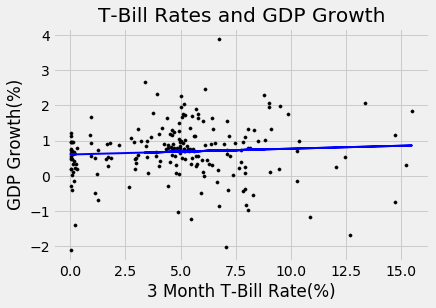

Coefficient:  0.0165730695461
Mean Squared Error: 0.641901
Variance: 0.004640


In [5]:
plt.scatter(x,y, color="black", s=10)
plt.plot(x,regr.predict(x), color = "blue", linewidth=2)
plt.ylabel("GDP Growth(%)")
plt.xlabel("3 Month T-Bill Rate(%)")
plt.title('T-Bill Rates and GDP Growth')
plt.show()
print('Coefficient: ', regr.coef_[0][0])
print('Mean Squared Error: %2f' % np.mean((regr.predict(x) - y)**2))
print('Variance: %2f' % regr.score(x,y))

## Conclusion
There is little to no linear correlation between T-Bill Rate and Percent Change in Real GDP. This is most evident by the negative value of the R-squared value of the linear regression. Thus, using more economic variables is mandatory to understand the elements behind GDP fluctuation.